# Recap

First we need access to data. 
- You can use this link to add the data to your drive: https://drive.google.com/drive/folders/1pHNxZVrlcKh5usWoNC_V7gR2WdeDutjv

- Then go inside the folder **CS_for_MedStudents_data** and you will see the folder **HAM10000**.
- Right click on the **HAM10000** folder and click on the **Add to my Drive** option.

Now you can run the next cell

In [38]:
#from google.colab import drive
#drive.mount('/content/drive')

In [39]:
# Check the directory
#data_dir = "/content/drive/My Drive/HAM10000"
data_dir = "/home/tobiascz/Datasets/HAM10000_with_classfolders"
#data_dir = "/home/tobiascz/Datasets/HAM10000_with_classfolders"

classes = [ 'actinic keratoses', 'basal cell carcinoma', 'benign keratosis-like lesions', 
           'dermatofibroma','melanoma', 'melanocytic nevi', 'vascular lesions']

In [40]:
import torchvision.transforms as transforms

# Imagenet values
norm_mean = (0.4914, 0.4822, 0.4465)
norm_std = (0.2023, 0.1994, 0.2010)

# define the transformations the images go through each time it is used for training
# includes augmentation AND normalization as described above
augmentation_train = transforms.Compose([
                                  # resize image to the network input size
                                  transforms.Resize((224,224)),
                                  # randomly perform a horizontal flip of the image
                                  transforms.RandomHorizontalFlip(),
                                  # rotate the image with a angle from 0 to 60 (chosen randomly)
                                  transforms.RandomRotation(degrees=60),
                                  # convert the image into a tensor so it can be processed by the GPU
                                  transforms.ToTensor(),
                                  # normalize the image with the mean and std of ImageNet
                                  transforms.Normalize(norm_mean, norm_std),
                                   ])

In [41]:
# no augmentation for the test data only resizing, conversion to tensor and normalization
augmentation_test = transforms.Compose([
                    transforms.Resize((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                    ])


In [42]:
import torchvision


toy_dataset_train = torchvision.datasets.MNIST(".", train=True, transform=None, target_transform=None, download=True)
toy_dataset_train = torchvision.datasets.MNIST(".", train=False, transform=None, target_transform=None, download=True)


print(data_dir)
# create an instance of the image folder class to load images by classes defined with the folders given
#dataset = torchvision.datasets.ImageFolder(root= data_dir, transform= augmentation_train)

/home/tobiascz/Datasets/HAM10000_with_classfolders


In [44]:
print(len(toy_dataset_train))
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

10000


In [45]:
import torch
from sklearn.model_selection import train_test_split

# get the total amount of images in the dataset
num_train = len(dataset)

# create a list of indices for the whole dataset
indices = list(range(num_train))

# get the class labels from the dataset object (0-6)
class_labels = dataset.targets

# define the percentage of data that is not used for training
split_size = 0.2

# call a function of sklarn that takes care of splitting the dataset into training and validation+testing
train_indices, test_indices, class_labels_train, class_labels_test = train_test_split(indices,
                                                                                       class_labels,
                                                                                       test_size=split_size,
                                                                                       shuffle=True,
                                                                                       stratify= class_labels,
                                                                                       random_state=42)

# call a function of sklearn that splits validation+training into validation and training
train_indices, val_indices = train_test_split(train_indices,
                                               test_size=split_size,
                                               shuffle=True,
                                               stratify= class_labels_train,
                                               random_state=42)

# Creating data samplers and loaders using the indices:
SubsetRandomSampler = torch.utils.data.sampler.SubsetRandomSampler

# create instances of a torch class for picking random samples from our dataset
train_samples = SubsetRandomSampler(train_indices)
val_samples = SubsetRandomSampler(val_indices)
test_samples = SubsetRandomSampler(test_indices)

In [46]:
# define the batch size for training, val and testing
batch_size, validation_batch_size, test_batch_size = 512, 512, 512

# create and instance of a dataloader for training
train_data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False,num_workers=4, sampler= train_samples)

# overwrite the dataset instance with the test augmentation (this is not nice code)
dataset = torchvision.datasets.ImageFolder(root= data_dir, transform=augmentation_test)
# create instances of a dataloaders for validation and testing
validation_data_loader = torch.utils.data.DataLoader(dataset, batch_size=validation_batch_size, shuffle=False, sampler=val_samples, num_workers=4)
test_data_loader = torch.utils.data.DataLoader(dataset, batch_size=test_batch_size, shuffle=False, sampler=test_samples, num_workers=4)

In [47]:
# Declare the network

from torch import nn
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on:",device)

num_classes = len(classes)
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, (5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, (5,5)) 
        self.fc1   = nn.Linear(16*54*54, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, num_classes)
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = LeNet()
net = net.to(device)

Running on: cuda


In [50]:
# Median Frequency Balancing

import numpy as np

# get the class labels of each image
class_labels = toy_dataset_train.targets
# empty array for counting instance of each class
count_labels = np.zeros(len(classes))
# empty array for weights of each class
class_weights = np.zeros(len(classes))

# populate the count array
for l in class_labels:
  count_labels[l] += 1

# get median count
median_freq = np.median(count_labels)

# calculate the weigths
for i in range(len(classes)):
  class_weights[i] = median_freq/count_labels[i]

# print the weights
for i in range(len(classes)):
    print(classes[i],":", class_weights[i])

IndexError: index 7 is out of bounds for axis 0 with size 7

Now we define the loss function with the weights

In [11]:
class_weights = torch.FloatTensor(class_weights).to(device)

# loss function
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [12]:
# optimizer

import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=1e-5)

# Evaluation functions

Here we write a function which calculates the accuracy of model based on the validation dataset.

In [13]:
from sklearn.metrics import accuracy_score

def get_num_correct(predicted, labels):
    '''
    This function is used to decide if the predicted and ground truth classes are same or not.
    args: 
    predicted = output of model
    labels = true output
    '''
    batch_len, correct= 0, 0
    batch_len = labels.size(0)
    correct = (predicted == labels).sum().item()
    # correct = [1,1,1,1,2,3,4,5] predicted = [1,2,1,1,,2,3,4,6]
    return batch_len, correct

def evaluate(model, val_loader):
    '''
    This function calculates the total accuracy of the model on the validation set.
    args:
    model = the network we want to evaluate
    val_loader = the validation data loader
    '''
    losses= 0
    num_samples_total=0
    correct_total=0
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs)
        _, predicted = torch.max(out, 1)
        loss = criterion(out, labels)
        losses += loss.item() 
        b_len, corr = get_num_correct(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
    accuracy = correct_total/num_samples_total
    losses = losses/len(val_loader)
    return losses, accuracy

# Training Loop

# Train and Validation Curves

To better understand whether our network is actually learning something, we plot the training and validation curves.

There are two types of curves:
- Loss Curves: Plotting the trend of the loss per epoch.
- Accuracy Curves: Plotting accuracy, that is the performance of our model per epoch.

# Common Training Errors

Let us look at some errors and how to detect them.



## No Backpropagation

In [14]:
# number of loops over the dataset
num_epochs = 5
accuracy = []
val_accuracy = []
losses = []
val_losses = []

# intialize the network
net_backprop = LeNet()
net_backprop = net_backprop.to(device)
optimizer = optim.Adam(net_backprop.parameters(), lr=1e-5)
print(net_backprop)
print("Started Training")

for epoch in tnrange(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in tqdm_notebook(enumerate(train_data_loader)):
        print(f"Iteration: {i+1}/{len(train_data_loader)}")
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_backprop(inputs)
        loss = criterion(outputs, labels)
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_num_correct(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    
    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(net_backprop, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=7, bias=True)
)
Started Training


Iteration: 1/13
Iteration: 2/13
Iteration: 3/13
Iteration: 4/13
Iteration: 5/13
Iteration: 6/13
Iteration: 7/13
Iteration: 8/13
Iteration: 9/13
Iteration: 10/13
Iteration: 11/13
Iteration: 12/13
Iteration: 13/13

Epoch: 1
Loss: 1.947  Accuracy:0.110
Validation Loss: 1.947  Val Accuracy: 0.110


Iteration: 1/13
Iteration: 2/13
Iteration: 3/13
Iteration: 4/13
Iteration: 5/13
Iteration: 6/13
Iteration: 7/13
Iteration: 8/13
Iteration: 9/13
Iteration: 10/13
Iteration: 11/13
Iteration: 12/13
Iteration: 13/13

Epoch: 2
Loss: 1.947  Accuracy:0.110
Validation Loss: 1.948  Val Accuracy: 0.110


Iteration: 1/13
Iteration: 2/13
Iteration: 3/13
Iteration: 4/13
Iteration: 5/13
Iteration: 6/13
Iteration: 7/13
Iteration: 8/13
Iteration: 9/13
Iteration: 10/13
Iteration: 11/13
Iteration: 12/13
Iteration: 13/13

Epoch: 3
Loss: 1.947  Accuracy:0.110
Validation Loss: 1.943  Val Accuracy: 0.110


Iteration: 1/13
Iteration: 2/13
Iteration: 3/13
Iteration: 4/13
Iteration: 5/13
Iteration: 6/13
Iteration: 7/13
Iteration: 8/13
Iteration: 9/13
Iteration: 10/13
Iteration: 11/13
Iteration: 12/13
Iteration: 13/13

Epoch: 4
Loss: 1.947  Accuracy:0.110
Validation Loss: 1.947  Val Accuracy: 0.110


Iteration: 1/13
Iteration: 2/13
Iteration: 3/13
Iteration: 4/13
Iteration: 5/13
Iteration: 6/13
Iteration: 7/13
Iteration: 8/13
Iteration: 9/13
Iteration: 10/13
Iteration: 11/13
Iteration: 12/13
Iteration: 13/13

Epoch: 5
Loss: 1.947  Accuracy:0.110
Validation Loss: 1.950  Val Accuracy: 0.110

Finished Training


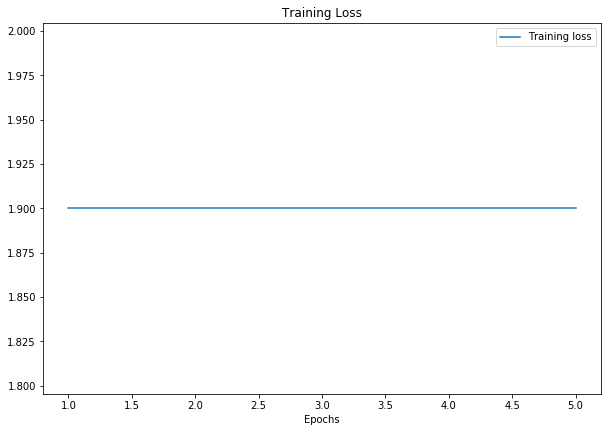

<Figure size 432x288 with 0 Axes>

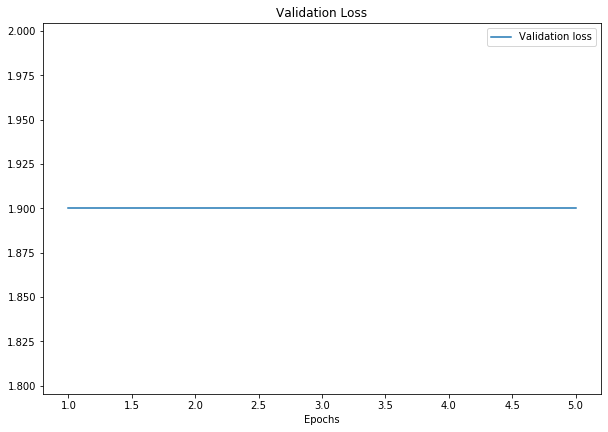

<Figure size 432x288 with 0 Axes>

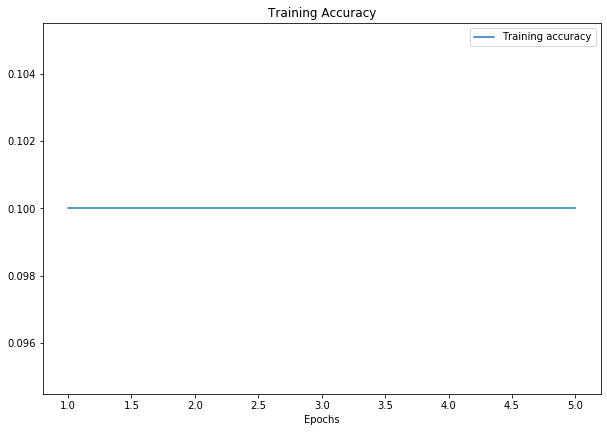

<Figure size 432x288 with 0 Axes>

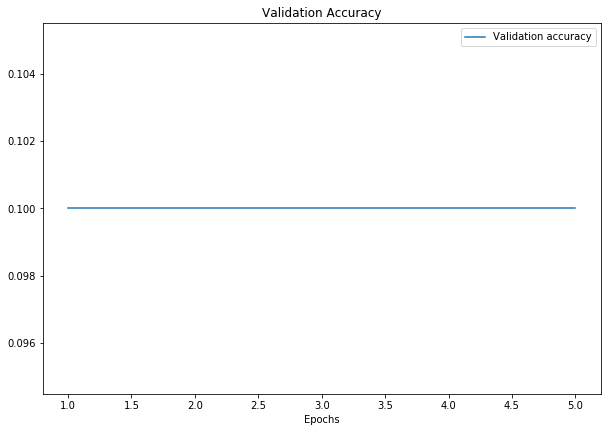

<Figure size 432x288 with 0 Axes>

In [15]:
# Rounding of the losses and accuracies to 2 decimal places.
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline 
n = 1 # round 2 places
losses = [round(x,n) for x in losses]
val_losses = [round(x,n) for x in val_losses]
accuracy = [round(x,n) for x in accuracy]
val_accuracy = [round(x,n) for x in val_accuracy]

epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, losses, label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()


fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, accuracy, label='Training accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, val_accuracy, label='Validation accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

## Data Scarcity

We need enough data to learn a good model. Less data means less learning.

Let's see how the performance is affected when we have less data.


In [16]:
# we use the test data for training instead.

train_data_loader_small = test_data_loader

In [24]:
# number of loops over the dataset
num_epochs = 10
accuracy = []
val_accuracy = []
losses = []
val_losses = []

# intialize the network
net_data = LeNet()
net_data = net_data.to(device)
optimizer = optim.Adam(net_data.parameters(), lr=1e-5)
print(net_data)
print("Started Training")

for epoch in tnrange(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in tqdm_notebook(enumerate(train_data_loader_small)):
        print(f"Iteration: {i+1}/{len(train_data_loader_small)}")
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_data(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_num_correct(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    
    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(net_data, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=7, bias=True)
)
Started Training


Iteration: 1/4
Iteration: 2/4
Iteration: 3/4
Iteration: 4/4

Epoch: 1
Loss: 0.599  Accuracy:0.020
Validation Loss: 1.943  Val Accuracy: 0.028


Iteration: 1/4
Iteration: 2/4
Iteration: 3/4
Iteration: 4/4

Epoch: 2
Loss: 0.597  Accuracy:0.033
Validation Loss: 1.942  Val Accuracy: 0.037


Iteration: 1/4
Iteration: 2/4
Iteration: 3/4
Iteration: 4/4

Epoch: 3
Loss: 0.596  Accuracy:0.030
Validation Loss: 1.937  Val Accuracy: 0.035


Iteration: 1/4
Iteration: 2/4
Iteration: 3/4
Iteration: 4/4

Epoch: 4
Loss: 0.594  Accuracy:0.044
Validation Loss: 1.932  Val Accuracy: 0.052


Iteration: 1/4
Iteration: 2/4
Iteration: 3/4
Iteration: 4/4

Epoch: 5
Loss: 0.593  Accuracy:0.054
Validation Loss: 1.924  Val Accuracy: 0.054


Iteration: 1/4
Iteration: 2/4
Iteration: 3/4
Iteration: 4/4

Epoch: 6
Loss: 0.591  Accuracy:0.061
Validation Loss: 1.915  Val Accuracy: 0.125


Iteration: 1/4
Iteration: 2/4
Iteration: 3/4
Iteration: 4/4

Epoch: 7
Loss: 0.590  Accuracy:0.200
Validation Loss: 1.920  Val Accuracy: 0.296


Iteration: 1/4
Iteration: 2/4
Iteration: 3/4
Iteration: 4/4

Epoch: 8
Loss: 0.587  Accuracy:0.318
Validation Loss: 1.907  Val Accuracy: 0.334


Iteration: 1/4
Iteration: 2/4
Iteration: 3/4
Iteration: 4/4

Epoch: 9
Loss: 0.585  Accuracy:0.334
Validation Loss: 1.904  Val Accuracy: 0.341


Iteration: 1/4
Iteration: 2/4
Iteration: 3/4
Iteration: 4/4

Epoch: 10
Loss: 0.584  Accuracy:0.322
Validation Loss: 1.906  Val Accuracy: 0.338

Finished Training


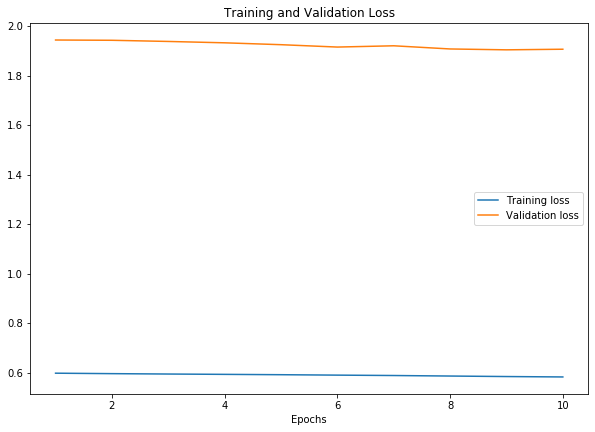

<Figure size 432x288 with 0 Axes>

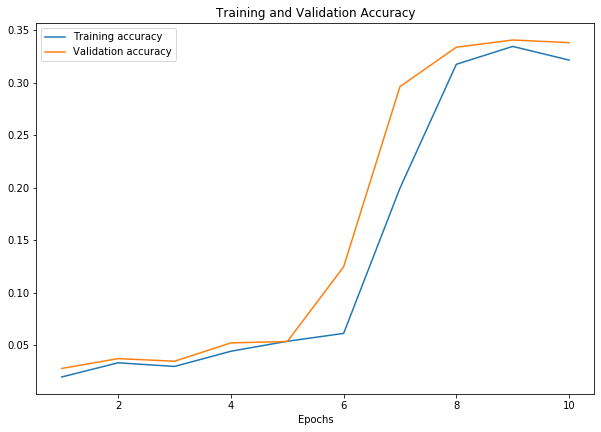

<Figure size 432x288 with 0 Axes>

In [25]:
epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, losses, label='Training loss')
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

#fig = plt.figure(figsize=(10, 15))
#plt.subplot(2,1,2)
#plt.plot(epoch, accuracy, label='Training accuracy')
#plt.plot(epoch, val_accuracy, label='Validation accuracy')
#plt.title('Training and Validation Accuracy')
#plt.xlabel('Epochs')
#plt.legend()
#plt.figure()
#plt.show()


## Choosing the Model

In [26]:
# Declare the network

from torch import nn
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = len(classes)
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, (5,5), padding=2)
        self.fc1   = nn.Linear(112*112*6, num_classes)
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net_small = SmallNet()
net_small = net_small.to(device)
optimizer = optim.Adam(net_small.parameters(), lr=1e-5)

In [27]:
# number of loops over the dataset
num_epochs = 5
accuracy = []
val_accuracy = []
losses = []
val_losses = []

print(net)
print("Started Training")

for epoch in tnrange(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in tqdm_notebook(enumerate(train_data_loader)):
        print(f"Iteration: {i+1}/{len(train_data_loader)}")
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_small(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_num_correct(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    
    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(net_small, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=7, bias=True)
)
Started Training


Iteration: 1/13
Iteration: 2/13
Iteration: 3/13
Iteration: 4/13
Iteration: 5/13
Iteration: 6/13
Iteration: 7/13
Iteration: 8/13
Iteration: 9/13
Iteration: 10/13
Iteration: 11/13
Iteration: 12/13
Iteration: 13/13

Epoch: 1
Loss: 1.918  Accuracy:0.267
Validation Loss: 1.914  Val Accuracy: 0.293


Iteration: 1/13
Iteration: 2/13
Iteration: 3/13
Iteration: 4/13
Iteration: 5/13
Iteration: 6/13
Iteration: 7/13
Iteration: 8/13
Iteration: 9/13
Iteration: 10/13
Iteration: 11/13
Iteration: 12/13
Iteration: 13/13

Epoch: 2
Loss: 1.843  Accuracy:0.396
Validation Loss: 1.793  Val Accuracy: 0.499


Iteration: 1/13
Iteration: 2/13
Iteration: 3/13
Iteration: 4/13
Iteration: 5/13
Iteration: 6/13
Iteration: 7/13
Iteration: 8/13
Iteration: 9/13
Iteration: 10/13
Iteration: 11/13
Iteration: 12/13
Iteration: 13/13

Epoch: 3
Loss: 1.801  Accuracy:0.461
Validation Loss: 1.758  Val Accuracy: 0.446


Iteration: 1/13
Iteration: 2/13
Iteration: 3/13
Iteration: 4/13
Iteration: 5/13
Iteration: 6/13
Iteration: 7/13
Iteration: 8/13
Iteration: 9/13
Iteration: 10/13
Iteration: 11/13
Iteration: 12/13
Iteration: 13/13

Epoch: 4
Loss: 1.761  Accuracy:0.470
Validation Loss: 1.755  Val Accuracy: 0.466


Iteration: 1/13
Iteration: 2/13
Iteration: 3/13
Iteration: 4/13
Iteration: 5/13
Iteration: 6/13
Iteration: 7/13
Iteration: 8/13
Iteration: 9/13
Iteration: 10/13
Iteration: 11/13
Iteration: 12/13
Iteration: 13/13

Epoch: 5
Loss: 1.731  Accuracy:0.481
Validation Loss: 1.742  Val Accuracy: 0.441

Finished Training


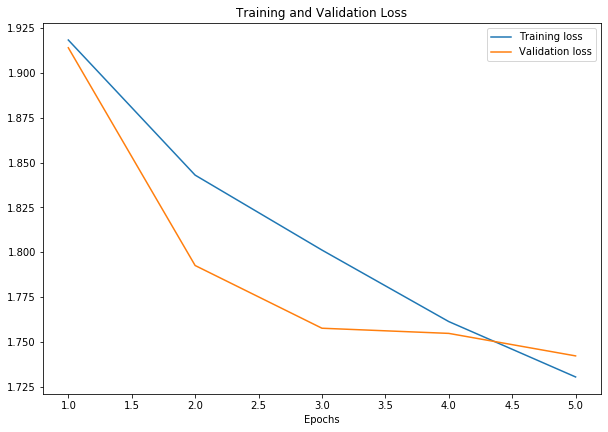

<Figure size 432x288 with 0 Axes>

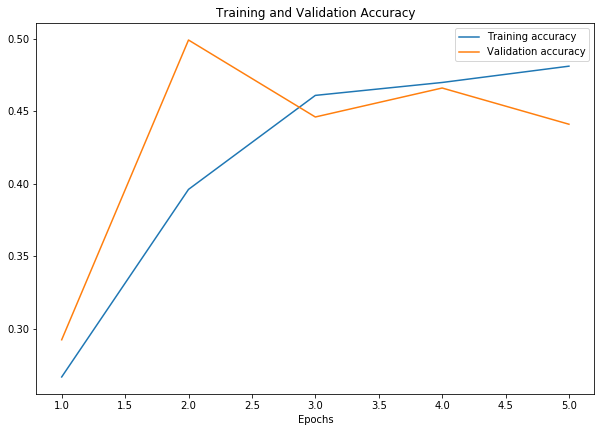

<Figure size 432x288 with 0 Axes>

In [28]:
epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, losses, label='Training loss')
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, accuracy, label='Training accuracy')
plt.plot(epoch, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()


## Learning Rate


In [29]:
net_lr = LeNet()
net_lr = net_lr.to(device)

# optimizer
import torch.optim as optim

optimizer_lr = optim.Adam(net_lr.parameters(), lr=10)

In [30]:
# number of loops over the dataset
num_epochs = 5
accuracy = []
val_accuracy = []
losses = []
val_losses = []

for epoch in tnrange(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in tqdm_notebook(enumerate(train_data_loader)):
        print(f"Iteration: {i+1}/{len(train_data_loader)}")
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer_lr.zero_grad()

        # forward + backward + optimize
        outputs = net_lr(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_lr.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_num_correct(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    
    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(net_lr, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')

Iteration: 1/13
Iteration: 2/13
Iteration: 3/13
Iteration: 4/13
Iteration: 5/13
Iteration: 6/13
Iteration: 7/13
Iteration: 8/13
Iteration: 9/13
Iteration: 10/13
Iteration: 11/13
Iteration: 12/13
Iteration: 13/13

Epoch: 1
Loss: 123415432112299.109  Accuracy:0.251
Validation Loss: 107588.732  Val Accuracy: 0.669


Iteration: 1/13
Iteration: 2/13
Iteration: 3/13
Iteration: 4/13
Iteration: 5/13
Iteration: 6/13
Iteration: 7/13
Iteration: 8/13
Iteration: 9/13
Iteration: 10/13
Iteration: 11/13
Iteration: 12/13
Iteration: 13/13

Epoch: 2
Loss: 250903.865  Accuracy:0.157
Validation Loss: 98809.119  Val Accuracy: 0.011


Iteration: 1/13
Iteration: 2/13
Iteration: 3/13
Iteration: 4/13
Iteration: 5/13
Iteration: 6/13
Iteration: 7/13
Iteration: 8/13
Iteration: 9/13
Iteration: 10/13
Iteration: 11/13
Iteration: 12/13
Iteration: 13/13

Epoch: 3
Loss: 120066.078  Accuracy:0.123
Validation Loss: 69161.664  Val Accuracy: 0.033


Iteration: 1/13
Iteration: 2/13
Iteration: 3/13
Iteration: 4/13
Iteration: 5/13
Iteration: 6/13
Iteration: 7/13
Iteration: 8/13
Iteration: 9/13
Iteration: 10/13
Iteration: 11/13
Iteration: 12/13
Iteration: 13/13

Epoch: 4
Loss: 60924.249  Accuracy:0.153
Validation Loss: 2235.023  Val Accuracy: 0.014


Iteration: 1/13
Iteration: 2/13
Iteration: 3/13
Iteration: 4/13
Iteration: 5/13
Iteration: 6/13
Iteration: 7/13
Iteration: 8/13
Iteration: 9/13
Iteration: 10/13
Iteration: 11/13
Iteration: 12/13
Iteration: 13/13

Epoch: 5
Loss: 1086.022  Accuracy:0.028
Validation Loss: 226.144  Val Accuracy: 0.011

Finished Training


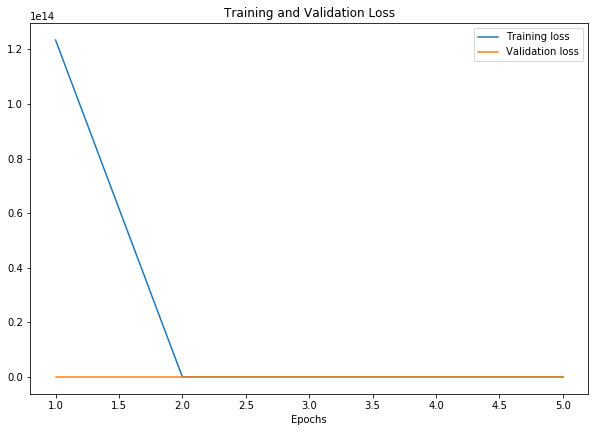

<Figure size 432x288 with 0 Axes>

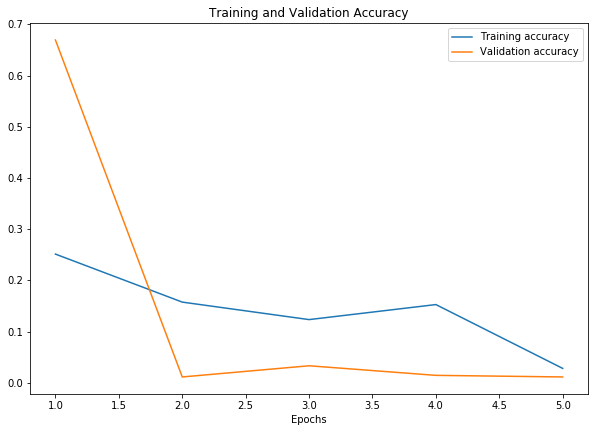

<Figure size 432x288 with 0 Axes>

In [31]:
epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, losses, label='Training loss')
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, accuracy, label='Training accuracy')
plt.plot(epoch, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()


## Loss Function

Choosing the correct loss functions is very important. In our task, we had an class imbalance in the dataset. So, we needed to use **weighted cross entropy loss function**.

Let's see how the performance changes if we use a **normal cross entropy loss**.

In [32]:
# loss function does not work with mnist (cause it is balanced)
criterion = nn.CrossEntropyLoss()

In [ ]:
# number of loops over the dataset
num_epochs = 5
accuracy = []
val_accuracy = []
losses = []
val_losses = []

net_lossfunc = LeNet()
net_lossfunc = net_lossfunc.to(device)
optimizer = optim.Adam(net_lossfunc.parameters(), lr=1e-5)

print("Started Training")

for epoch in tnrange(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    print("...")
    for i, data in tqdm_notebook(enumerate(train_data_loader)):
        print(f"Iteration: {i+1}/{len(train_data_loader)}")
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_lossfunc(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_num_correct(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    
    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(net_lossfunc, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')

In [ ]:
epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, losses, label='Training loss')
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, accuracy, label='Training accuracy')
plt.plot(epoch, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

# Homework - Train a model which achieves 80% accuracy